# Applicability Domain Estimation

This notebook demonstrates how to use scikit-mol's applicability domain estimators to assess whether new compounds are within the domain of applicability of a trained model.

We'll explore two different approaches:
1. Using Morgan binary fingerprints with a k-Nearest Neighbors based applicability domain
2. Using count-based Morgan fingerprints with dimensionality reduction and a leverage-based applicability domain

First, let's import the necessary libraries and load our dataset:

In [1]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scikit_mol.conversions import SmilesToMolTransformer
from scikit_mol.fingerprints import MorganFingerprintTransformer
from scikit_mol.applicability import KNNApplicabilityDomain, LeverageApplicabilityDomain

## Load and Prepare Data

In [2]:
# Load the dataset
# Results are better with the full set, but it takes longer to run, so for the notebook documentation we standard use a subset.
# The subset has been filtered to only include nicely predicted compounds, and is thus artificial.

full_set = False

if full_set:
    csv_file = "SLC6A4_active_excape_export.csv"
    if not os.path.exists(csv_file):
        import urllib.request

        url = "https://ndownloader.figshare.com/files/25747817"
        urllib.request.urlretrieve(url, csv_file)
        percentile = 95
else:
    csv_file = "../../tests/data/SLC6A4_active_excapedb_subset.csv"
    percentile = 90
data = pd.read_csv(csv_file)

# Add RDKit mol objects
PandasTools.AddMoleculeColumnToFrame(data, smilesCol="SMILES")
print(f"{data.ROMol.isna().sum()} out of {len(data)} SMILES failed in conversion")

# Split into train/val/test
X = data.ROMol
y = data.pXC50

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

0 out of 200 SMILES failed in conversion


## Example 1: k-NN Applicability Domain with Binary Morgan Fingerprints

In this example, we'll use binary Morgan fingerprints and a k-NN based applicability domain with Tanimoto distance.
This is particularly suitable for binary fingerprints as the Tanimoto coefficient is a natural similarity measure for them.

In [3]:
# Create pipeline for binary fingerprints
binary_fp_pipe = Pipeline(
    [
        ("fp", MorganFingerprintTransformer(fpSize=2048, radius=2)),
        ("rf", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ]
)

# Train the model
binary_fp_pipe.fit(X_train, y_train)

# Get predictions and errors
y_pred_test = binary_fp_pipe.predict(X_test)
abs_errors = np.abs(y_test - y_pred_test)

# Create and fit k-NN AD estimator
knn_ad = KNNApplicabilityDomain(
    n_neighbors=3, distance_metric="tanimoto", percentile=percentile
)
knn_ad.fit(binary_fp_pipe.named_steps["fp"].transform(X_train))

# Fit threshold using validation set
knn_ad.fit_threshold(binary_fp_pipe.named_steps["fp"].transform(X_val))

# Get AD scores for test set
knn_scores = knn_ad.transform(binary_fp_pipe.named_steps["fp"].transform(X_test))

Let's visualize the relationship between prediction errors and AD scores:

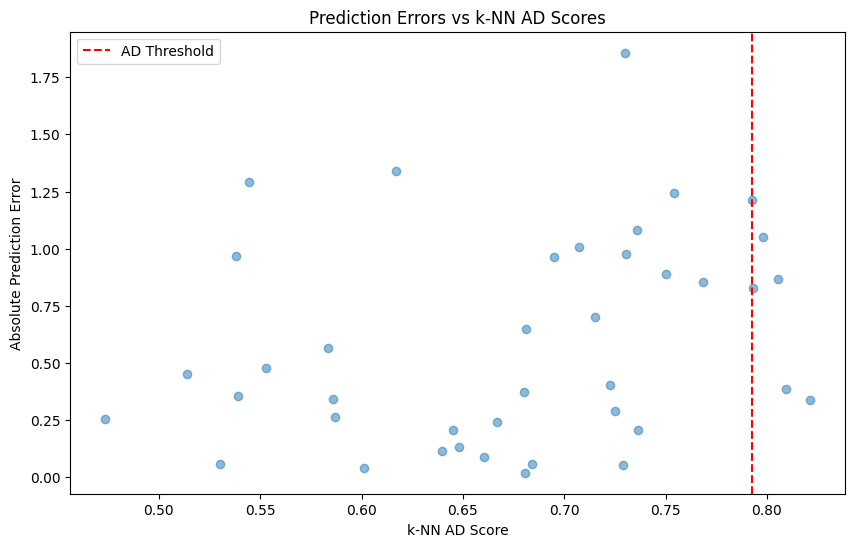

95th percentile of errors inside domain: 1.31
95th percentile of errors outside domain: 1.17
Fraction of samples outside domain: 0.15


In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(knn_scores, abs_errors, alpha=0.5)
plt.axvline(x=knn_ad.threshold_, color="r", linestyle="--", label="AD Threshold")
plt.xlabel("k-NN AD Score")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Errors vs k-NN AD Scores")
plt.legend()
plt.show()

# Calculate error statistics
in_domain = knn_ad.predict(binary_fp_pipe.named_steps["fp"].transform(X_test))
errors_in = abs_errors[in_domain == 1]
errors_out = abs_errors[in_domain == -1]

print(f"95th percentile of errors inside domain: {np.percentile(errors_in, 95):.2f}")
print(f"95th percentile of errors outside domain: {np.percentile(errors_out, 95):.2f}")
print(f"Fraction of samples outside domain: {(in_domain == -1).mean():.2f}")

## Example 2: Leverage-based AD with Count-based Morgan Fingerprints

In this example, we'll use count-based Morgan fingerprints, reduce their dimensionality with PCA,
and apply a leverage-based applicability domain estimator.

In [5]:
# Create pipeline for count-based fingerprints with PCA
count_fp_pipe = Pipeline(
    [
        ("fp", MorganFingerprintTransformer(fpSize=2048, radius=2, useCounts=True)),
        ("pca", PCA(n_components=0.9)),  # Keep 90% of variance
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

# Train the model
count_fp_pipe.fit(X_train, y_train)

# Get predictions and errors
y_pred_test = count_fp_pipe.predict(X_test)
abs_errors = np.abs(y_test - y_pred_test)

# Create and fit leverage AD estimator
leverage_ad = LeverageApplicabilityDomain(percentile=percentile)
X_train_transformed = count_fp_pipe.named_steps["scaler"].transform(
    count_fp_pipe.named_steps["pca"].transform(
        count_fp_pipe.named_steps["fp"].transform(X_train)
    )
)
leverage_ad.fit(X_train_transformed)

# Fit threshold using validation set
X_val_transformed = count_fp_pipe.named_steps["scaler"].transform(
    count_fp_pipe.named_steps["pca"].transform(
        count_fp_pipe.named_steps["fp"].transform(X_val)
    )
)
leverage_ad.fit_threshold(X_val_transformed)

# Get AD scores for test set
X_test_transformed = count_fp_pipe.named_steps["scaler"].transform(
    count_fp_pipe.named_steps["pca"].transform(
        count_fp_pipe.named_steps["fp"].transform(X_test)
    )
)
leverage_scores = leverage_ad.transform(X_test_transformed)

Visualize the relationship between prediction errors and leverage scores:

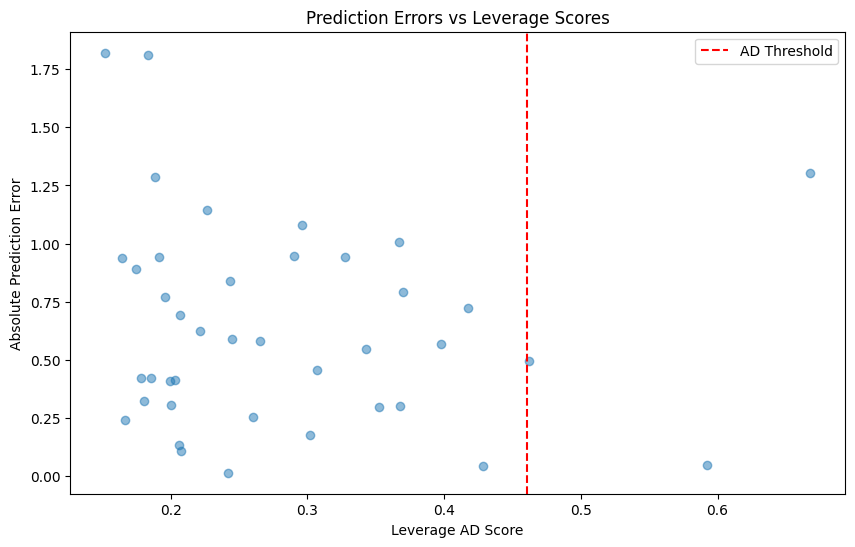

95th percentile of errors inside domain: 1.39
95th percentile of errors outside domain: 1.22
Fraction of samples outside domain: 0.07


In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(leverage_scores, abs_errors, alpha=0.5)
plt.axvline(x=leverage_ad.threshold_, color="r", linestyle="--", label="AD Threshold")
plt.xlabel("Leverage AD Score")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Errors vs Leverage Scores")
plt.legend()
plt.show()

# Calculate error statistics
in_domain = leverage_ad.predict(X_test_transformed)
errors_in = abs_errors[in_domain == 1]
errors_out = abs_errors[in_domain == -1]

print(f"95th percentile of errors inside domain: {np.percentile(errors_in, 95):.2f}")
print(f"95th percentile of errors outside domain: {np.percentile(errors_out, 95):.2f}")
print(f"Fraction of samples outside domain: {(in_domain == -1).mean():.2f}")

## Testing Famous Drugs

Let's test some well-known drugs to see if they fall within our model's applicability domain:

In [7]:
# Define famous drugs
famous_drugs = {
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "Viagra": "CCc1nn(C)c2c(=O)[nH]c(nc12)c3cc(ccc3OCC)S(=O)(=O)N4CCN(C)CC4",
    "Heroin": "CN1CC[C@]23[C@H]4Oc5c(O)ccc(CC1[C@H]2C=C[C@@H]4O3)c5",
}


# Function to process a drug through both AD pipelines
def check_drug_applicability(smiles, name):
    mol = Chem.MolFromSmiles(smiles)

    # k-NN AD
    fp_binary = binary_fp_pipe.named_steps["fp"].transform([mol])
    knn_score = knn_ad.transform(fp_binary)[0][0]
    knn_status = "Inside" if knn_ad.predict(fp_binary)[0] == 1 else "Outside"

    # Leverage AD
    fp_count = count_fp_pipe.named_steps["fp"].transform([mol])
    fp_pca = count_fp_pipe.named_steps["pca"].transform(fp_count)
    fp_scaled = count_fp_pipe.named_steps["scaler"].transform(fp_pca)
    leverage_score = leverage_ad.transform(fp_scaled)[0][0]
    leverage_status = "Inside" if leverage_ad.predict(fp_scaled)[0] == 1 else "Outside"

    return {
        "knn_score": knn_score,
        "knn_status": knn_status,
        "leverage_score": leverage_score,
        "leverage_status": leverage_status,
    }


# Process each drug
results = []
for name, smiles in famous_drugs.items():
    result = check_drug_applicability(smiles, name)
    results.append(
        {
            "Drug": name,
            "k-NN Score": result["knn_score"],
            "k-NN Status": result["knn_status"],
            "Leverage Score": result["leverage_score"],
            "Leverage Status": result["leverage_status"],
        }
    )

# Display results
pd.DataFrame(results).set_index("Drug")

,k-NN Score,k-NN Status,Leverage Score,Leverage Status
Drug,,,,
Aspirin,0.813836,Outside,0.154726,Inside
Viagra,0.829481,Outside,0.374886,Inside
Heroin,0.852061,Outside,0.107878,Inside


Let's visualize where these drugs fall in our AD plots:

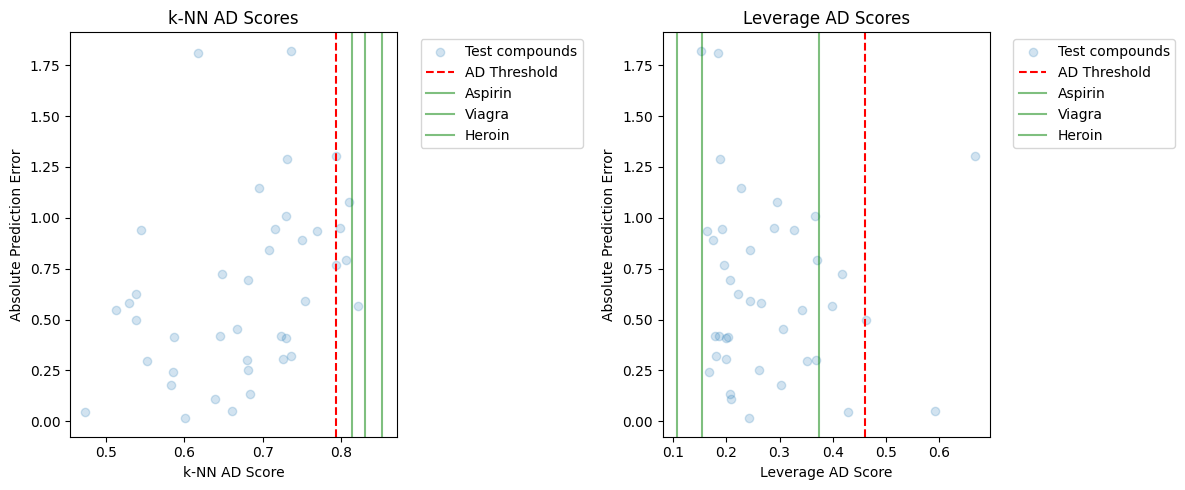

In [8]:
# Plot for k-NN AD
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(knn_scores, abs_errors, alpha=0.2, label="Test compounds")
plt.axvline(x=knn_ad.threshold_, color="r", linestyle="--", label="AD Threshold")

for result in results:
    plt.axvline(x=result["k-NN Score"], color="g", alpha=0.5, label=f"{result['Drug']}")

plt.xlabel("k-NN AD Score")
plt.ylabel("Absolute Prediction Error")
plt.title("k-NN AD Scores")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot for Leverage AD
plt.subplot(1, 2, 2)
plt.scatter(leverage_scores, abs_errors, alpha=0.2, label="Test compounds")
plt.axvline(x=leverage_ad.threshold_, color="r", linestyle="--", label="AD Threshold")

for result in results:
    plt.axvline(
        x=result["Leverage Score"], color="g", alpha=0.5, label=f"{result['Drug']}"
    )

plt.xlabel("Leverage AD Score")
plt.ylabel("Absolute Prediction Error")
plt.title("Leverage AD Scores")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

## Conclusions

This notebook demonstrated two different approaches to applicability domain estimation:

1. The k-NN based approach with binary fingerprints and Tanimoto distance provides a chemical similarity-based assessment
of whether new compounds are similar enough to the training set.

2. The leverage-based approach with count-based fingerprints and dimensionality reduction focuses on the statistical
novelty of compounds in the reduced feature space.

The famous drugs we tested showed varying degrees of being within the applicability domain, which makes sense given
that our training set is focused on SLC6A4 actives, while these drugs have different primary targets.

The error analysis shows that compounds outside the applicability domain tend to have higher prediction errors (when using the full set),
validating the usefulness of these approaches for identifying potentially unreliable predictions.